In [144]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Regression

In [202]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [203]:
dr = '~/Projects/video-qoe-labeling/new-data/Skype/'
dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Freezes': np.int32, 'Freezelength': np.float64, 'Quality': np.float64}
df_reg = pd.read_table(dr + 'all-data.txt', delim_whitespace=True, dtype = dtype)
df_reg['BitRate'] /= 100  # transforming BitRate to percentages

In [204]:
# get (X, y) and set fold
features = ['BitRate', 'FreezeRatio', 'Freezes', 'Freezelength']
X, y = np.array(df_reg[features]), np.array(df_reg['Quality'])
mse = {}
mae = {}
fold = 5

regressors = {'Random Forest': RandomForestRegressor(random_state = 1), 
               'Nearest Neighbors': KNeighborsRegressor(),
               'SVM': SVR(),
               'MLP': MLPRegressor(random_state = 1, max_iter = 10000),
               'AdaBoost': AdaBoostRegressor(random_state = 1)
              }

params = {'Random Forest': {'n_estimators': range(1, 21), 'criterion': ('mse', 'mae')},
          'Nearest Neighbors': {'n_neighbors':range(1, 11)},
          'SVM': {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]},
          'MLP': {'hidden_layer_sizes': [(10,), (20,), (40,), (80,), (10,10), (20, 20), (40, 40), (80, 80)], 
                  'alpha': [0.0001, 0.001, 0.01, 0.1],
                  'activation': ('logistic', 'tanh', 'relu'), 
                  'solver': ('lbfgs', 'sgd', 'adam')},
          'AdaBoost': {'n_estimators': [10, 20, 40, 80], 'learning_rate': [0.01, 0.1, 1, 10]}
         }

# function for obtaining best estimator using grid search
def grid_search_reg(estimator, params, scoring):
    reg = GridSearchCV(estimator, params, scoring = scoring)
    reg.fit(X, y)
    return (reg.best_estimator_, reg.best_score_)

# function for performing k-fold cross validation on the regressors
def k_Fold_CV_reg(estimator, n):
    mse = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        pred = estimator.fit(X[train], y[train]).predict(X[test])
        mse.append(mean_squared_error(y[test], pred))
    return mse

best_regressors_mse = {}
best_regressors_mae = {}
for k in regressors:
    best_regressors_mse[k], _ = grid_search_reg(regressors[k], params[k], 'neg_mean_squared_error')
    best_regressors_mae[k], _ = grid_search_reg(regressors[k], params[k], 'neg_mean_absolute_error')
    mse[k] = k_Fold_CV_reg(best_regressors_mse[k], fold)
    mae[k] = k_Fold_CV_reg(best_regressors_mae[k], fold)

for k, v in mse.items():
    print(k)
    rmse = np.sqrt(v)
    print("{}_fold RMSE: ".format(fold), np.around(rmse, decimals = 3))
    print("Average RMSE: {0:0.3f}".format(np.mean(rmse)))
    print("#################################")

for k, v in mae.items():
    print(k)
    print("{}_fold MAE: ".format(fold), np.around(v, decimals = 3))
    print("Average MAE: {0:0.3f}".format(np.mean(v)))
    print("#################################")

In [205]:
best_regressors_mse = {'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
          n_estimators=10, random_state=1),
 'MLP': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
        solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'Nearest Neighbors': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
 'SVM': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)}

best_regressors_mae = {'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
          n_estimators=10, random_state=1),
 'MLP': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
        solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'Nearest Neighbors': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
 'SVM': SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)}

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

mserr = {}
for k, v in best_regressors_mse.items():
    pred = v.fit(X_train, y_train).predict(X_test)
    mserr[k] = mean_squared_error(y_test, pred)

maerr = {}
for k, v in best_regressors_mae.items():
    pred = v.fit(X_train, y_train).predict(X_test)
    maerr[k] = mean_absolute_error(y_test, pred)

for k, v in mserr.items():
    print(k)
    print("MSE: ", np.around(v, decimals = 3))
    print("#################################")
    
for k, v in maerr.items():
    print(k)
    print("MAE: ", np.around(v, decimals = 3))
    print("#################################")

In [222]:
def to_label(score, thresh):
    label = []
    for s in np.nditer(score):
        if s < thresh[0]:
            label.append(0)
        elif s < thresh[1]:
            label.append(1)
        else:
            label.append(2)
    return np.array(label, dtype = int) 

def optimize_thresh(regressor, X_train, y_train, X_test, y_test, t1_range, top_num):
    i = 0
    thresh_accuracy = []
    model = regressor.fit(X_train, y_train)
    pred = model.predict(X_train) 
    # find optimal thresholds from training set
    for t1 in t1_range:
        for t2 in np.arange(t1+1, 4.01, 0.05):
            y_label_true = to_label(y_train, (t1, t2))
            y_label_pred = to_label(pred, (t1, t2))
            thresh_accuracy.append(((t1, t2), accuracy_score(y_label_true, y_label_pred)))
    thresh_accuracy.sort(key = lambda x:x[1], reverse = True)
    # determine average thresholds
    thresh = [x[0] for x in thresh_accuracy[:top_num]]
    avg_thresh = np.average(thresh, axis = 0) 
    # find accuracy on test set
    pred = model.predict(X_test)
    y_label_true = to_label(y_test, avg_thresh)
    y_label_pred = to_label(pred, avg_thresh)   
    return avg_thresh, accuracy_score(y_label_true, y_label_pred)

In [223]:
t1_range = np.arange(2, 3.01, 0.05)
thresh_accuracy_mse = {}

for k, reg in best_regressors_mse.items():
    thresh_accuracy_mse[k] = optimize_thresh(reg, X_train, y_train, X_test, y_test, t1_range, 1)

thresh_accuracy_mae = {}
for k, reg in best_regressors_mae.items():
    thresh_accuracy_mae[k] = optimize_thresh(reg, X_train, y_train, X_test, y_test, t1_range, 1)

In [224]:
thresh_accuracy_mse

{'AdaBoost': (array([ 2.,  4.]), 0.82666666666666666),
 'MLP': (array([ 2.35,  3.85]), 0.82666666666666666),
 'Nearest Neighbors': (array([ 2.3,  4. ]), 0.76000000000000001),
 'Random Forest': (array([ 2.,  4.]), 0.88),
 'SVM': (array([ 2.,  3.]), 0.89333333333333331)}

In [225]:
print('regressors with minimized mean squared error')
for k, v in thresh_accuracy_mse.items():
    print(k)
    print("Optimal thresholds: {}, Test accuracy: {}".format(np.around(v[0], decimals = 2), np.around(v[1], decimals = 3)))
    print("#################################")
    
print()
print('regressors with minimized mean absolute error')
for k, v in thresh_accuracy_mae.items():
    print(k)
    print("Optimal thresholds: {}, Test accuracy: {}".format(np.around(v[0], decimals = 2), np.around(v[1], decimals = 3)))
    print("#################################")

regressors with minimized mean squared error
AdaBoost
Optimal thresholds: [ 2.  4.], Test accuracy: 0.827
#################################
MLP
Optimal thresholds: [ 2.35  3.85], Test accuracy: 0.827
#################################
Nearest Neighbors
Optimal thresholds: [ 2.3  4. ], Test accuracy: 0.76
#################################
Random Forest
Optimal thresholds: [ 2.  4.], Test accuracy: 0.88
#################################
SVM
Optimal thresholds: [ 2.  3.], Test accuracy: 0.893
#################################

regressors with minimized mean absolute error
AdaBoost
Optimal thresholds: [ 2.  4.], Test accuracy: 0.827
#################################
MLP
Optimal thresholds: [ 2.35  3.85], Test accuracy: 0.827
#################################
Nearest Neighbors
Optimal thresholds: [ 2.3  4. ], Test accuracy: 0.76
#################################
Random Forest
Optimal thresholds: [ 2.  4.], Test accuracy: 0.88
#################################
SVM
Optimal thresholds: [ 2.  3.

# S2, S6 and Pixel Analysis

In [174]:
df = {}
df['s2'] = pd.read_table(dr + 's2.txt', delim_whitespace=True, dtype = dtype)
df['s6'] = pd.read_table(dr + 's6.txt', delim_whitespace=True, dtype = dtype)
df['px'] = pd.read_table(dr + 'pixel.txt', delim_whitespace=True, dtype = dtype)

In [175]:
for d in df.values():
    d['BitRate'] /= 100     # transforming BitRate to percentages

In [176]:
X = {}
y = {}
# y_bin = {}
for k, d in df.items():
    X[k], y[k] = np.array(d[features]), np.array(d['Quality'])
    # y_bin[k] = label_binarize(y[k], classes = classes)

#mae = {}

thresh = {}
accuracy = {}
'''
acc = {}
prec = {}
recl = {}
f1 = {}
'''
for r, reg in best_regressors_mae.items():
    #mae[r] = {}
    thresh[r] = {}
    '''
    acc[r] = {}
    prec[r] = {}
    recl[r] = {} 
    f1[r] = {}    
    '''
    for k in X.keys():
        #mae[r][k] = {}
        thresh[r][k] = {}
        '''
        acc[r][k] = {}
        prec[r][k] = {}
        recl[r][k] = {} 
        f1[r][k] = {}
        '''
        for k1 in X.keys():
            if k1 != k: # train and test on other datasets
                #pred = reg.fit(X[k], y[k]).predict(X[k1])
                #mae[r][k][k1] = mean_absolute_error(y[k1], pred)
                thresh[r][k][k1] = optimize_thresh(reg, X[k], y[k], X[k1], y[k1], t1_range, 10)
                #y_label_true = to_label(y[k1], thresh_accuracy_mae[r][0])
                #y_label_pred = to_label(pred, thresh_accuracy_mae[r][0])
                #acc[r][k][k1] = accuracy_score(y_label_true, y_label_pred)
                #prec[r][k][k1] = precision_score(y_label_true, y_label_pred, average = None) 
                #recl[r][k][k1] = recall_score(y_label_true, y_label_pred, average = None) 
                #f1[r][k][k1] = f1_score(y_label_true, y_label_pred, average = None)  
            else:    # train and test on itself
                X_tr, X_te, y_tr, y_te = train_test_split(X[k], y[k], test_size = 0.25, random_state = 1)
                thresh[r][k][k] = optimize_thresh(reg, X_tr, y_tr, X_te, y_te, t1_range, 10)
                #pred = reg.fit(X_tr, y_tr).predict(X_te)
                #mae[r][k][k1] = mean_absolute_error(y_te, pred)
                #y_label_true = to_label(y_te, thresh_accuracy_mae[r][0])
                #y_label_pred = to_label(pred, thresh_accuracy_mae[r][0])
                #acc[r][k][k] = accuracy_score(y_label_true, y_label_pred)
                #prec[r][k][k] = precision_score(y_label_true, y_label_pred, average = None) 
                #recl[r][k][k] = recall_score(y_label_true, y_label_pred, average = None) 
                #f1[r][k][k] = f1_score(y_label_true, y_label_pred, average = None)

def print_results(dic, title):
    print('#################################')
    print('{} results:'.format(title))
    for k, v in dic.items():
        print(k)
        for k1, v1 in v.items():
            print("training set: {}".format(k1))
            for k2, v2 in v1.items():
                print("optimal thresholds on {}: {}, {}".format(k2, np.around(v2[0][0], decimals = 3), np.around(v2[0][1], decimals = 3)))
                print("optimal accuracy on {}: {}".format(k2, np.around(v2[1], decimals = 3)))
        print()
    print()

In [183]:
acc = {}
prec = {}
recl = {}
f1 = {}
for r, reg in best_regressors_mae.items():
    acc[r] = {}
    prec[r] = {}
    recl[r] = {} 
    f1[r] = {}    
    for k in X.keys():
        acc[r][k] = {}
        prec[r][k] = {}
        recl[r][k] = {} 
        f1[r][k] = {}
        for k1 in X.keys():
            if k1 != k: # train and test on other datasets
                pred = reg.fit(X[k], y[k]).predict(X[k1])
                y_label_true = to_label(y[k1], thresh_accuracy_mse[r][0])
                y_label_pred = to_label(pred, thresh_accuracy_mse[r][0])
                acc[r][k][k1] = accuracy_score(y_label_true, y_label_pred)
                prec[r][k][k1] = precision_score(y_label_true, y_label_pred, average = None) 
                recl[r][k][k1] = recall_score(y_label_true, y_label_pred, average = None) 
                f1[r][k][k1] = f1_score(y_label_true, y_label_pred, average = None)  
            else:    # train and test on itself
                X_tr, X_te, y_tr, y_te = train_test_split(X[k], y[k], test_size = 0.25, random_state = 1)
                pred = reg.fit(X_tr, y_tr).predict(X_te)
                y_label_true = to_label(y_te, thresh_accuracy_mse[r][0])
                y_label_pred = to_label(pred, thresh_accuracy_mse[r][0])
                acc[r][k][k] = accuracy_score(y_label_true, y_label_pred)
                prec[r][k][k] = precision_score(y_label_true, y_label_pred, average = None) 
                recl[r][k][k] = recall_score(y_label_true, y_label_pred, average = None) 
                f1[r][k][k] = f1_score(y_label_true, y_label_pred, average = None)

/home/ysqyang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ysqyang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ysqyang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ysqyang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ysqyang/anacon

In [184]:
def print_results(dic, title):
    print('#################################')
    print('{} results:'.format(title))
    for k, v in dic.items():
        print(k)
        for k1, v1 in v.items():
            print("training set: {}".format(k1))
            for k2, v2 in v1.items():
                print("{} on {}: {}".format(title, k2, np.around(v2, decimals = 3)))
        print()
    print()

In [185]:
print_results(acc, 'accuracy')
print_results(prec, 'precision')
print_results(recl, 'recall')
print_results(f1, 'f1_score')

#################################
accuracy results:
AdaBoost
training set: s2
accuracy on s2: 0.84
accuracy on s6: 0.86
accuracy on px: 0.77
training set: s6
accuracy on s2: 0.9
accuracy on s6: 0.84
accuracy on px: 0.71
training set: px
accuracy on s2: 0.83
accuracy on s6: 0.72
accuracy on px: 0.92

MLP
training set: s2
accuracy on s2: 0.72
accuracy on s6: 0.76
accuracy on px: 0.8
training set: s6
accuracy on s2: 0.8
accuracy on s6: 0.84
accuracy on px: 0.79
training set: px
accuracy on s2: 0.78
accuracy on s6: 0.7
accuracy on px: 0.84

Nearest Neighbors
training set: s2
accuracy on s2: 0.76
accuracy on s6: 0.76
accuracy on px: 0.79
training set: s6
accuracy on s2: 0.81
accuracy on s6: 0.64
accuracy on px: 0.82
training set: px
accuracy on s2: 0.81
accuracy on s6: 0.73
accuracy on px: 0.84

Random Forest
training set: s2
accuracy on s2: 0.76
accuracy on s6: 0.81
accuracy on px: 0.74
training set: s6
accuracy on s2: 0.84
accuracy on s6: 0.88
accuracy on px: 0.69
training set: px
accurac

# Visualization

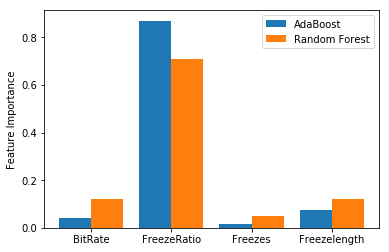

In [237]:
p1 = plt.bar(np.arange(len(features)), best_regressors_mse['AdaBoost'].feature_importances_, width = -0.4, align = 'edge')
p2 = plt.bar(np.arange(len(features)), best_regressors_mse['Random Forest'].feature_importances_, width = 0.4, align = 'edge')
plt.xticks(np.arange(len(features)), tuple(features))
plt.ylabel('Feature Importance')
plt.legend((p1, p2), ('AdaBoost', 'Random Forest'))
plt.show()

num_classes = 3

def plot_roc(fpr, tpr, roc_auc, clf_name, lb):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}, Class {}'.format(clf_name, lb))
    plt.legend(loc="lower right")
    plt.show()
        
def get_roc(X_tr, y_tr, X_te, y_te, clf):
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_score = ovr(clf).fit(X_tr, y_tr).predict_proba(X_te)
    for i in range(len(num_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return (fpr, tpr, roc_auc)

for k, v in best_regressors.items():
    fpr, tpr, roc_auc = get_roc(X_train, y_train, X_test, y_test, v)
    for i in classes:
        plot_roc(fpr[i], tpr[i], roc_auc[i], k, i)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(reg_name, xx, yy, **params):
    Z = best_regressors_mae[reg_name].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = to_label(Z, thresh_accuracy_mae[reg_name][0])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

colors = ['red', 'green', 'blue']
cmap = mpl.colors.ListedColormap(colors)
rg = np.arange(0, 1.01, 0.01)
x1, x2, lb = np.array(df_reg['BitRate']), np.array(df_reg['FreezeRatio']), np.array(df_reg['Quality'])
xx1, xx2 = make_meshgrid(rg, rg)
for reg, name in zip(list(best_regressors_mae.values()), list(best_regressors_mae.keys())):
    plot_contours(name, xx1, xx2, cmap=cmap, alpha=0.8)
    plt.scatter(x1, x2, c = lb, cmap=cmap, s=20, edgecolors='k')
    plt.xlim(rg.min(), rg.max())
    plt.ylim(rg.min(), rg.max())
    plt.xlabel('Bit Rate')
    plt.ylabel('Freeze Ratio')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title(name)
    plt.show()